## Clustering Discussion Guide
Author: David Yerrington (SF)

Clustering offers a lot of oppporunities for discovery within datasets without labels.  The goal of clustering is mainly to group points by some metric of similarity.  Within sklearn, there are almost a dozen methods that provide clustering capabilities all have different strengths and weaknesses.  Not all methods hinge on their ability of pattern recognition but also come at heavy efficiency tradeoffs between memory and CPU that should also be considered, especially with big datasets.

<table border="1" class="colwidths-given docutils">
<colgroup>
<col width="15%">
<col width="16%">
<col width="20%">
<col width="27%">
<col width="22%">
</colgroup>
<thead valign="bottom">
<tr class="row-odd"><th class="head">Method name</th>
<th class="head">Parameters</th>
<th class="head">Scalability</th>
<th class="head">Usecase</th>
<th class="head">Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr class="row-even"><td><a class="reference internal" href="#k-means"><span class="std std-ref">K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large <code class="docutils literal"><span class="pre">n_samples</span></code>, medium <code class="docutils literal"><span class="pre">n_clusters</span></code> with
<a class="reference internal" href="#mini-batch-kmeans"><span class="std std-ref">MiniBatch code</span></a></td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#affinity-propagation"><span class="std std-ref">Affinity propagation</span></a></td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="#mean-shift"><span class="std std-ref">Mean-shift</span></a></td>
<td>bandwidth</td>
<td>Not scalable with <code class="docutils literal"><span class="pre">n_samples</span></code></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#spectral-clustering"><span class="std std-ref">Spectral clustering</span></a></td>
<td>number of clusters</td>
<td>Medium <code class="docutils literal"><span class="pre">n_samples</span></code>, small <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Ward hierarchical clustering</span></a></td>
<td>number of clusters</td>
<td>Large <code class="docutils literal"><span class="pre">n_samples</span></code> and <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="#hierarchical-clustering"><span class="std std-ref">Agglomerative clustering</span></a></td>
<td>number of clusters, linkage type, distance</td>
<td>Large <code class="docutils literal"><span class="pre">n_samples</span></code> and <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="#dbscan"><span class="std std-ref">DBSCAN</span></a></td>
<td>neighborhood size</td>
<td>Very large <code class="docutils literal"><span class="pre">n_samples</span></code>, medium <code class="docutils literal"><span class="pre">n_clusters</span></code></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr class="row-odd"><td><a class="reference internal" href="mixture.html#mixture"><span class="std std-ref">Gaussian mixtures</span></a></td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr class="row-even"><td><a class="reference internal" href="#birch"><span class="std std-ref">Birch</span></a></td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <code class="docutils literal"><span class="pre">n_clusters</span></code> and <code class="docutils literal"><span class="pre">n_samples</span></code></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>

In [24]:
print(__doc__)

import time
import warnings

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

%matplotlib inline

Automatically created module for IPython interactive environment


### Create some random data using sklearn's `datasets` module

To compare a few different algorithms that we will be using, we will create a few scenarios in which to examine.  
> Most of these examples are adapted from sklearn's documentation.

In [25]:

np.random.seed(0)

# ============
# Generate datasets. We choose the size big enough to see the scalability
# of the algorithms, but not too big to avoid too long running times
# ============
n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

# blobs with varied variances
varied = datasets.make_blobs(n_samples=n_samples,
                             cluster_std=[1.0, 2.5, 0.5],
                             random_state=random_state)



### Dynamically initialized clustering models

We will setup a few parameters that we can use as defaults as we fit our models to the different pre-generated datasets. This is convenient so we don't have to literally write the same code for each model we want to initialize and fit data for.

In [26]:
default_base = {'quantile': .3,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 3}

datasets = [
    (noisy_circles, {
                     'damping': .77, 'preference': -240, 
                     'quantile': .2, 'n_clusters': 2
    }),
    (noisy_moons,   {'damping': .75, 'preference': -220, 'n_clusters': 2}),
    (varied,        {'eps': .18, 'n_neighbors': 2}),
    (aniso,         {'eps': .15, 'n_neighbors': 2}),
    (blobs,         {}),
    (no_structure,  {})
]



### Iterate and Generate Plot Figures

This is what's called a data-driven pattern.  Because most of our models and data are pre-defined, the process that produces the application (plotting), we don't need to change the code in order to add more data or new models to fit data to those models. We only need to define new entries in `datasets` and `clustering_algorithms` objects to add additional plots to evaluate.

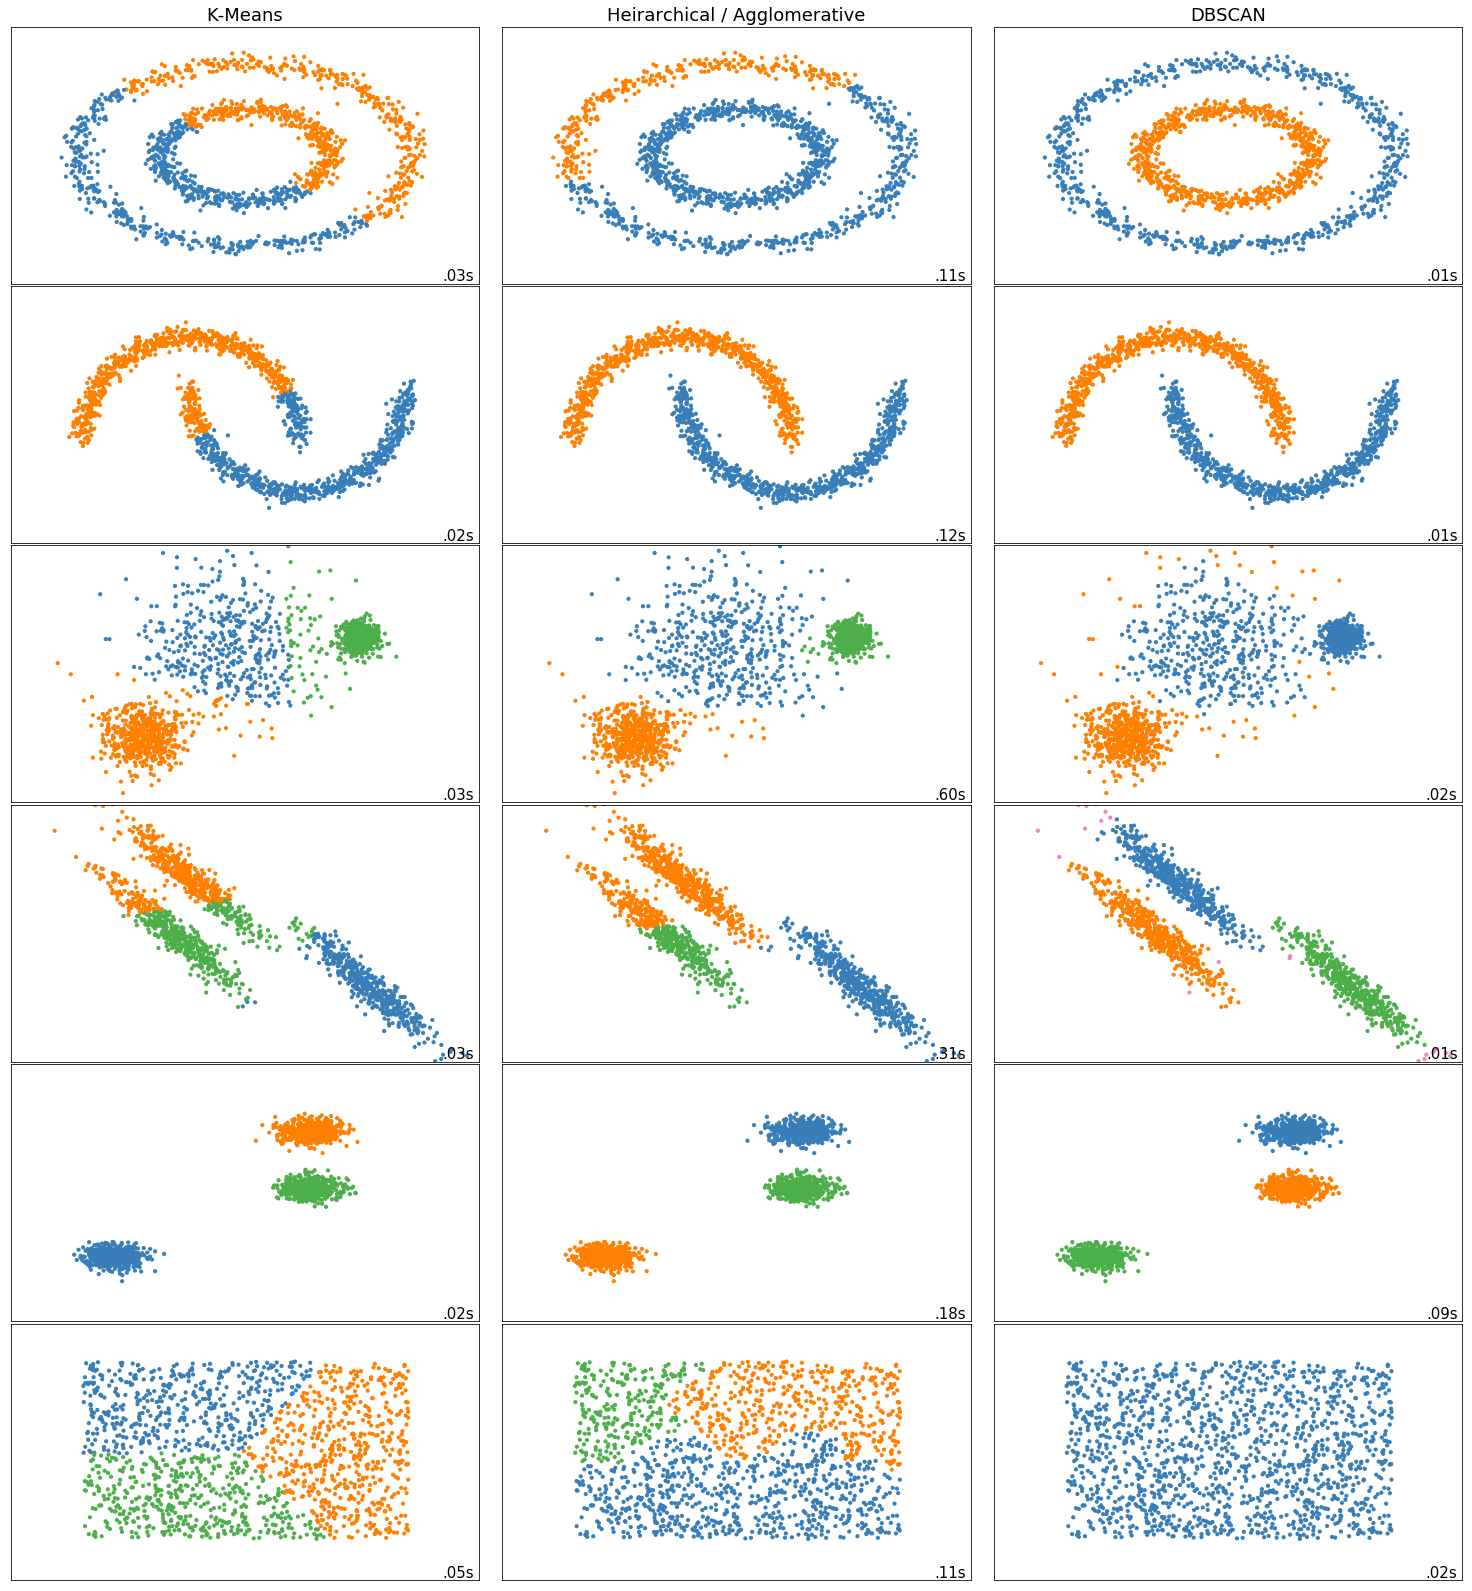

In [27]:

plt.figure(figsize=(9 * 2 + 3, 22.5))
plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05,
                    hspace=.01)

plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(datasets):
    
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params['n_neighbors'], include_self=False)
    
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects -- add / update / or extend these for more methods
    # Check out the docs for more!
    # ============
    k_means = cluster.KMeans(n_clusters=params['n_clusters'])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params['n_clusters'], linkage='ward',
        connectivity=connectivity)
    dbscan = cluster.DBSCAN(eps=params['eps'])

    clustering_algorithms = (
        ('K-Means', k_means),
        ('Heirarchical / Agglomerative', ward),
        ('DBSCAN', dbscan),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(np.int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(datasets), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=18)

        colors = np.array(list(islice(cycle(['#377eb8', '#ff7f00', '#4daf4a',
                                             '#f781bf', '#a65628', '#984ea3',
                                             '#999999', '#e41a1c', '#dede00']),
                                      int(max(y_pred) + 1))))
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(.99, .01, ('%.2fs' % (t1 - t0)).lstrip('0'),
                 transform=plt.gca().transAxes, size=15,
                 horizontalalignment='right')
        plot_num += 1

plt.show()

### Take some time and play with this code a little bit and even consider changing some parameters.
A few ideas to explore:

- Render a dendrogram for heirarchical clustering and see the potential for tuning the distance/height parameter.
- Pick a specific case within one of the dataset, identifying the tradeoffs between the different clustering methods.
- Initialize, fit, and manually adjust hyperparameters after some discussion about how to improve a specific case. 
- Pick a dataset, pick a model, build a pipeline, ask "what should we do?", then take turns inviting different members of the class to code.